# Faizaan Ali | HW3 | Neural Networks

## Data Selection

In [5]:
%pip install ucimlrepo

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset (https://archive.ics.uci.edu/dataset/327/phishing+websites)
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

I was skimming through the UCI ML datasets and came across the website phishing detection collection. I thought it would be a potentially strong candidate for neural network testing, as it has 11,000+ samples and 30 features.  

## Part 1: Custom Neural Network

In [7]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, task="classification", lr=0.01, seed=42):
        """
        layer_sizes: list of form [n_input, n_hidden, ..., n_output]
        task: "classification" or "regression"
        """
        np.random.seed(seed)
        self.task = task
        self.lr = lr
        self.L = len(layer_sizes) - 1  # number of layers

        # init parameters
        self.W = {}
        self.b = {}
        for l in range(1, len(layer_sizes)):
            self.W[l] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * 0.01
            self.b[l] = np.zeros((layer_sizes[l], 1))

    # activations
    def _relu(self, Z):
        return np.maximum(0, Z)

    def _relu_deriv(self, Z):
        return (Z > 0).astype(float)

    def _sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    # forward prop
    def forward(self, X):
        A = X
        self.cache = {"A0": X}

        for l in range(1, self.L):
            Z = self.W[l] @ A + self.b[l]
            A = self._relu(Z)
            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A

        # output layer
        ZL = self.W[self.L] @ A + self.b[self.L]
        if self.task == "classification":
            AL = self._sigmoid(ZL)
        else:  # regression
            AL = ZL

        self.cache[f"Z{self.L}"] = ZL
        self.cache[f"A{self.L}"] = AL
        return AL

    # cost function for gd
    def cost(self, Y, Y_hat):
        m = Y.shape[1]
        if self.task == "classification":
            return -np.mean(Y * np.log(Y_hat + 1e-8) + (1 - Y) * np.log(1 - Y_hat + 1e-8))
        else:  # MSE
            return np.mean((Y_hat - Y) ** 2)

    # backpropagation
    def backward(self, Y):
        grads = {}
        m = Y.shape[1]

        # output layer gradient
        AL = self.cache[f"A{self.L}"]
        if self.task == "classification":
            dZ = AL - Y
        else:  # regression
            dZ = 2 * (AL - Y)

        for l in reversed(range(1, self.L + 1)):
            A_prev = self.cache[f"A{l-1}"]
            grads[f"dW{l}"] = (1/m) * dZ @ A_prev.T
            grads[f"db{l}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

            if l > 1:
                Z_prev = self.cache[f"Z{l-1}"]
                dZ = (self.W[l].T @ dZ) * self._relu_deriv(Z_prev)

        self.grads = grads

    # gradient descent
    def _update_params(self):
        for l in range(1, self.L + 1):
            self.W[l] -= self.lr * self.grads[f"dW{l}"]
            self.b[l] -= self.lr * self.grads[f"db{l}"]

    # training loop
    def train(self, X, Y, epochs=1000, verbose=False):
        for i in range(epochs):
            Y_hat = self.forward(X)
            loss = self.cost(Y, Y_hat)
            self.backward(Y)
            self._update_params()

            if verbose and i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")

    # inference
    def predict(self, X, threshold=0.5):
        Y_hat = self.forward(X)
        if self.task == "classification":
            return (Y_hat >= threshold).astype(int)
        return Y_hat


### Evaluate Custom Framework

In [10]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# load data
phishing_websites = fetch_ucirepo(id=327)

# data
X = phishing_websites.data.features.copy()
y = phishing_websites.data.targets.copy()

print("Feature columns:\n", X.columns.tolist())
print("Target columns:\n", y.columns.tolist())
print("Target value counts:\n", y.value_counts())

if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
    y = y.iloc[:, 0]
y = (y + 1) // 2

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit ONLY on train
X_test = scaler.transform(X_test)        # apply to test (no leak)

# Transpose
X_train = X_train.T                      # shape: (n_features, m_train)
X_test = X_test.T                        # shape: (n_features, m_test)
y_train = np.array(y_train).reshape(1, -1)
y_test = np.array(y_test).reshape(1, -1)

# Mini-batch training
def train_minibatch(nn, X, Y, epochs=300, batch_size=128):
    m = X.shape[1]

    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X_shuff = X[:, perm]
        Y_shuff = Y[:, perm]

        for i in range(0, m, batch_size):
            X_batch = X_shuff[:, i:i+batch_size]
            Y_batch = Y_shuff[:, i:i+batch_size]

            nn.forward(X_batch)
            nn.backward(Y_batch)
            nn._update_params()

        if epoch % 50 == 0:
            preds = nn.forward(X)
            loss = nn.cost(Y, preds)
            print(f"Epoch {epoch} | Training loss: {loss:.4f}")

# init + train
nn = NeuralNetwork(
    layer_sizes=[X_train.shape[0], 32, 16, 1],
    task="classification",
    lr=0.01
)
train_minibatch(nn, X_train, y_train)
y_pred_scores = nn.predict(X_test)
y_pred_labels = (y_pred_scores > 0.5).astype(int).reshape(-1)
y_true = y_test.reshape(-1)

# metrics
acc = accuracy_score(y_true, y_pred_labels)
prec = precision_score(y_true, y_pred_labels, zero_division=0)
rec = recall_score(y_true, y_pred_labels, zero_division=0)
print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")


Feature columns:
 ['having_ip_address', 'url_length', 'shortining_service', 'having_at_symbol', 'double_slash_redirecting', 'prefix_suffix', 'having_sub_domain', 'sslfinal_state', 'domain_registration_length', 'favicon', 'port', 'https_token', 'request_url', 'url_of_anchor', 'links_in_tags', 'sfh', 'submitting_to_email', 'abnormal_url', 'redirect', 'on_mouseover', 'rightclick', 'popupwindow', 'iframe', 'age_of_domain', 'dnsrecord', 'web_traffic', 'page_rank', 'google_index', 'links_pointing_to_page', 'statistical_report']
Target columns:
 ['result']
Target value counts:
 result
 1        6157
-1        4898
Name: count, dtype: int64
Epoch 0 | Training loss: 0.6912
Epoch 50 | Training loss: 0.6866
Epoch 100 | Training loss: 0.6861
Epoch 150 | Training loss: 0.1878
Epoch 200 | Training loss: 0.1645
Epoch 250 | Training loss: 0.1435
Test Accuracy:  0.9498
Test Precision: 0.9403
Test Recall:    0.9716


Using a mini-batch trained neural network with two hidden layers (32 and 16 units), the model achieved 94.98% test accuracy, with 94.03% precision and 97.16% recall on the phishing website classification task. The high recall indicates the model is particularly effective at correctly identifying phishing websites, which is important in security applications where missing malicious sites is costly. The steady decrease in training loss and strong evaluation metrics suggest that mini-batch gradient descent enabled efficient learning while keeping strong generalization performance on unseen test data. Mini-batch serves as a strong middle ground; stochastic can be noisy and less smooth, while using the full dataset takes much longer per epoch.

### Analysis



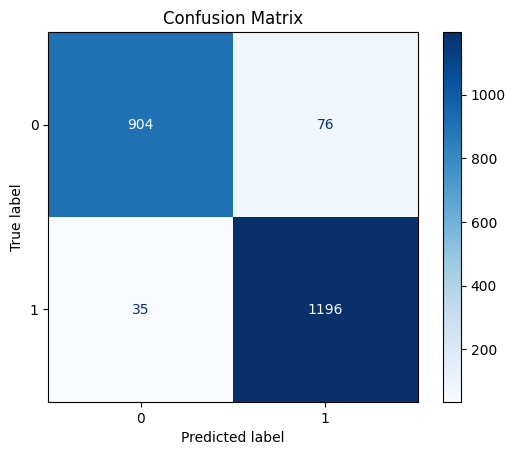

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

As one can see from this confusion matrix, the custom neural network framework performed quite well on the phishing dataset, with both low false positive and false negative rates. This definitly showcases the power of the neural network architecture in extracting hidden patterns from the large dataset and creating an accurate separation between classes.

## Part 2: Library Implementation

In [12]:
%pip install tensorflow

In [13]:
# core library
import tensorflow as tf

# NN building blocks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# optimizers (handle GD too)
from tensorflow.keras.optimizers import SGD, Adam

# useful loss functions
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

# eval metrics
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

# standard resources
import numpy as np
import matplotlib.pyplot as plt


Guide: https://www.geeksforgeeks.org/deep-learning/implementing-neural-networks-using-tensorflow/

TensorFlow (tensorflow as tf) provides the core deep learning framework, including automatic differentiation and efficient tensor operations that enable forward and backward propagation during neural network training. Its autodiff engine computes gradients of the loss with respect to model parameters, which is essential for backpropagation.

The Sequential model and Dense layers from tensorflow.keras are used to define the neural network architecture. Dense implements fully connected layers that perform linear transformations followed by nonlinear activations during forward propagation, while Sequential provides a simple way to stack layers in order.

Optimizers such as SGD and Adam implement gradient descent–based parameter updates. They use the gradients computed during backpropagation to update the model weights, controlling how fast and in what manner the model learns from the data.

Loss functions like BinaryCrossentropy define the cost function for binary classification, measuring how well the model’s predicted probabilities match the true class labels. This loss value is what the optimizer seeks to minimize.

The Accuracy metric is used during evaluation to measure the proportion of correctly classified samples, similarly with Precision and Recall to get a more holistic model review.

Finally, NumPy is used for numerical preprocessing and data manipulation, while Matplotlib enables visualization of training curves and model predictions, helping to analyze convergence behavior and model performance.

### EDA

Number of samples: 11055
Number of features: 30

Target distribution (0 = legitimate, 1 = phishing):
        Count  Proportion
result                   
0        4898    0.443057
1        6157    0.556943


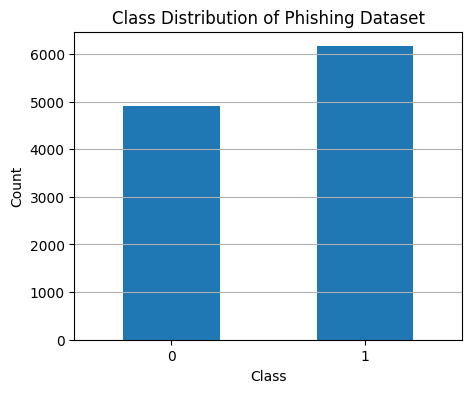


Feature summary statistics:


,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.913885,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.405991,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])

# target distribution
class_counts = y.value_counts().sort_index()
class_ratios = y.value_counts(normalize=True).sort_index()

eda_df = pd.DataFrame({
    "Count": class_counts,
    "Proportion": class_ratios
})

print("\nTarget distribution (0 = legitimate, 1 = phishing):")
print(eda_df)

# plot distribution
plt.figure(figsize=(5, 4))
class_counts.plot(kind="bar")
plt.title("Class Distribution of Phishing Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Summary stats of features
print("\nFeature summary statistics:")
display(X.describe())


Dataset is very clean, meaning little cleaning is required. There are no missing values, and the target distribution is close enough to 50/50 such that we don't need to augment synthetic values.

### Library-Based Implementation


--- Training with Raw data ---
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - binary_accuracy: 0.5804 - loss: 0.8065 - precision_2: 0.5743 - recall_2: 0.9510 - val_binary_accuracy: 0.7841 - val_loss: 0.4937 - val_precision_2: 0.7600 - val_recall_2: 0.9066
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - binary_accuracy: 0.8033 - loss: 0.4579 - precision_2: 0.7704 - recall_2: 0.9083 - val_binary_accuracy: 0.8932 - val_loss: 0.3276 - val_precision_2: 0.8836 - val_recall_2: 0.9354
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.8863 - loss: 0.3186 - precision_2: 0.8678 - recall_2: 0.9367 - val_binary_accuracy: 0.9118 - val_loss: 0.2558 - val_precision_2: 0.9142 - val_recall_2: 0.9324
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.9050 - loss: 0.2582 - precision_2: 0.8998 - recall_2: 0.9326 - val_binary_accuracy: 0.9220 - val_loss: 0.2218 - val_precision_2: 0.9205 - val_recall_2: 0.9443
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

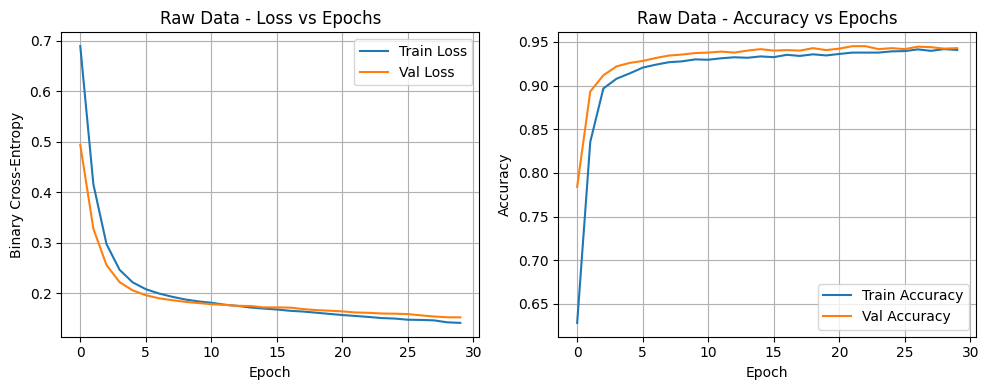


--- Training with Normalized data ---
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.7162 - loss: 0.5731 - precision_3: 0.7204 - recall_3: 0.7933 - val_binary_accuracy: 0.8711 - val_loss: 0.3821 - val_precision_3: 0.8762 - val_recall_3: 0.9006
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8824 - loss: 0.3547 - precision_3: 0.8880 - recall_3: 0.9004 - val_binary_accuracy: 0.9152 - val_loss: 0.2763 - val_precision_3: 0.9204 - val_recall_3: 0.9314
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9109 - loss: 0.2683 - precision_3: 0.9136 - recall_3: 0.9276 - val_binary_accuracy: 0.9305 - val_loss: 0.2261 - val_precision_3: 0.9333 - val_recall_3: 0.9453
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9219 - loss: 0.2199 - precision_3: 0.9180 - recall_3: 0.9413 - val_binary_accuracy: 0.9327 - val_loss: 0.2005 - val_precision_3: 0.9352 - val_recall_3: 0.9473
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s

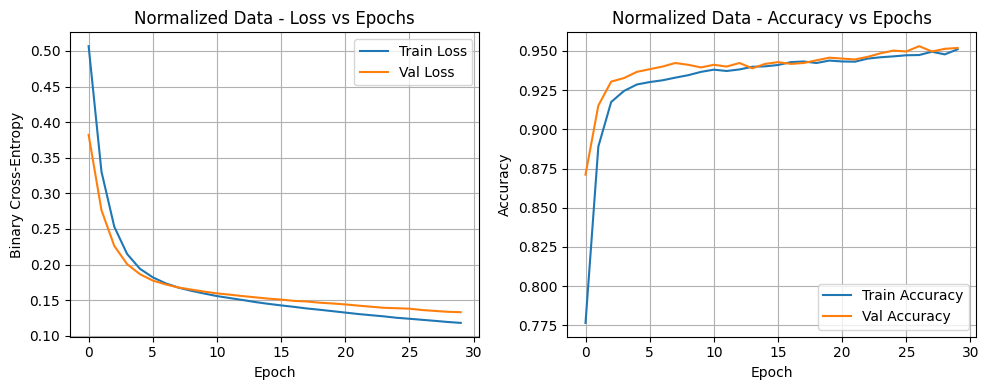

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# get data again
if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
    y = y.iloc[:, 0]
y = (y + 1) // 2  # ensure 0/1

# Train/test split (20% test + seed = 42 + stratify to balance classes)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# normalize x values (experiment)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_raw)
X_test_norm = scaler.transform(X_test_raw)

# Loop over both raw and normalized datasets
datasets = {
    "Raw": (X_train_raw, X_test_raw),
    "Normalized": (X_train_norm, X_test_norm)
}

for name, (X_tr, X_te) in datasets.items():
    print(f"\n--- Training with {name} data ---")

    # Build model
    model = Sequential([
        Input(shape=(X_tr.shape[1],)),  # number of features
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # relatively low learning rate
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(threshold=0.5), Precision(), Recall()]
    )

    # Train
    history = model.fit(
        X_tr, y_train,
        epochs=30,
        batch_size=128,   # mini-batch
        validation_split=0.2,   # 20% of train for inside epoch eval
        verbose=1
    )

    # Evaluate
    test_loss, test_acc, test_prec, test_rec = model.evaluate(X_te, y_test, verbose=0)
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test Precision: {test_prec:.4f}")
    print(f"Test Recall:    {test_rec:.4f}")

    # Plot training curves
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{name} Data - Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
    plt.title(f"{name} Data - Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


This implementation uses TensorFlow/Keras to build a 2-layer neural network for binary classification. The model has one hidden layer with 32 neurons using ReLU activation (allows the network to capture non-linear relationships in the data) followed by a single sigmoid output neuron to produce probabilities for binary classification. The loss function is Binary Cross-Entropy, which is appropriate for binary outcomes, and optimization is performed using the Adam optimizer (learning rate = 0.001), an adaptive gradient method that improves convergence stability compared to standard gradient descent. Training is performed using mini-batch gradient descent (batch size = 128) for 30 epochs, with a validation split of 20% of the training data to monitor generalization during training. In this simulation, no explicit regularization techniques (e.g., dropout or L2 weight decay) are used. But we do use normalization, specificially using StandardScaler to assess its effect on convergence and performance versus raw data.

The final results show strong generalization performance, with 94.71% test accuracy, 94.42% precision, and 96.18% recall on the normalized data (slightly better than on raw data), indicating that the model is both accurate and well-balanced in identifying positive and negative phishing cases. The close equal precision and recall scores suggest that the model does not strongly favor one class over the other, which is desirable in security-related tasks. Overall, the combination of ReLU activations, sigmoid output, Adam optimization, and mini-batching, results in stable training and high predictive performance.

### Hyperparameter Search

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Helper function
def create_model(input_dim, learning_rate):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Random grid search space
param_space = {
    "batch_size": [16, 32, 64, 100],
    "epochs": [100, 200, 300, 400],
    "learning_rate": [1e-2, 1e-3, 5e-4]
}

n_iterations = 10
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = 0
best_params = None

for i in range(n_iterations):
    # Randomly sample parameters
    batch_size = random.choice(param_space["batch_size"])
    epochs = random.choice(param_space["epochs"])
    learning_rate = random.choice(param_space["learning_rate"])

    cv_scores = []

    for train_idx, val_idx in cv.split(X_train_raw, y_train):
        X_train = X_train_raw.iloc[train_idx]
        X_val = X_train_raw.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]

        tf.keras.backend.clear_session()  # prevent slowdown

        model = create_model(X_train.shape[1], learning_rate)

        early_stop = EarlyStopping(
            monitor="loss",
            patience=10,
            restore_best_weights=True,
            verbose=0
        )

        model.fit(
            X_train, y_train_fold,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            callbacks=[early_stop]
        )

        y_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int)
        acc = accuracy_score(y_val_fold, y_pred)
        cv_scores.append(acc)

    mean_score = np.mean(cv_scores)
    print(f"Iter {i+1} | bs={batch_size}, ep={epochs}, lr={learning_rate} > CV acc={mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = {
            "batch_size": batch_size,
            "epochs": epochs,
            "learning_rate": learning_rate
        }

print("\nBest parameters found:", best_params)
print(f"Best CV accuracy: {best_score:.4f}")


Iter 1 | bs=32, ep=200, lr=0.001 > CV acc=0.9590
Iter 2 | bs=32, ep=200, lr=0.001 > CV acc=0.9612
Iter 3 | bs=64, ep=100, lr=0.01 > CV acc=0.9603
Iter 4 | bs=16, ep=400, lr=0.01 > CV acc=0.9508
Iter 5 | bs=100, ep=100, lr=0.01 > CV acc=0.9587
Iter 6 | bs=100, ep=100, lr=0.01 > CV acc=0.9594
Iter 7 | bs=16, ep=300, lr=0.01 > CV acc=0.9527
Iter 8 | bs=16, ep=200, lr=0.0005 > CV acc=0.9574
Iter 9 | bs=32, ep=400, lr=0.001 > CV acc=0.9604
Iter 10 | bs=64, ep=300, lr=0.0005 > CV acc=0.9556

Best parameters found: {'batch_size': 32, 'epochs': 200, 'learning_rate': 0.001}
Best CV accuracy: 0.9612


Neural Network Test Accuracy: 0.9665

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       980
           1       0.97      0.97      0.97      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

Confusion Matrix:


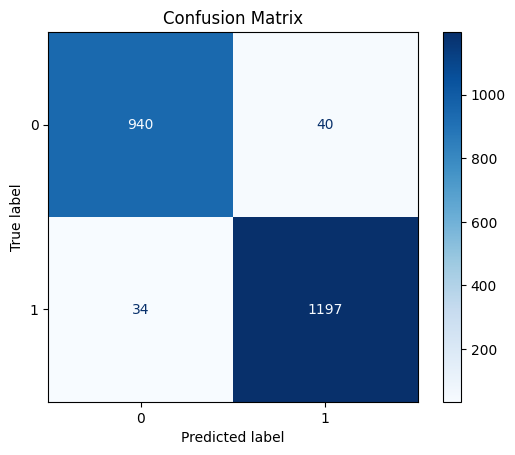

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Build model (same architecture used during CV)
nn_model = Sequential([
    Input(shape=(X_train_raw.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train with best hyperparameters
nn_model.fit(
    X_train_raw, y_train,
    epochs=200,
    batch_size=32,
    verbose=0
)

# Predict on test set
y_pred_probs = nn_model.predict(X_test_raw, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Neural Network Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()



In this task, we selected hyperparameters for the neural network using a random search strategy over a predefined range of plausible values. The hyperparameters tuned were the batch size, number of epochs, and learning rate, which directly influence convergence speed and model performance. Random search was chosen over grid search because it allows exploring the hyperparameter space more efficiently and often finds competitive configurations with fewer training runs, which is helpful given the computational cost of neural network training.

During training, we implemented early stopping, which prevents overfitting by stopping training once the training loss stops improving for a set number of epochs. While we did not include explicit regularization techniques such as dropout or L2 weight decay, early stopping acts as a form of implicit regularization. The Adam optimizer was used because it adaptively adjusts learning rates for each parameter, improving convergence stability/speed compared to standard gradient descent, especially when using mini-batches.

The overall idea was to efficiently identify a combination of hyperparameters that balances training speed, convergence, and generalization without overcomplicating the model. By evaluating performance using 3-fold Stratified Cross-Validation, it was ensured that the selected parameters generalize well across different subsets of the data, reducing the risk of overfitting.

## 6000-Level Comparison

Logistic Regression Test Accuracy: 0.9290

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       980
           1       0.92      0.95      0.94      1231

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



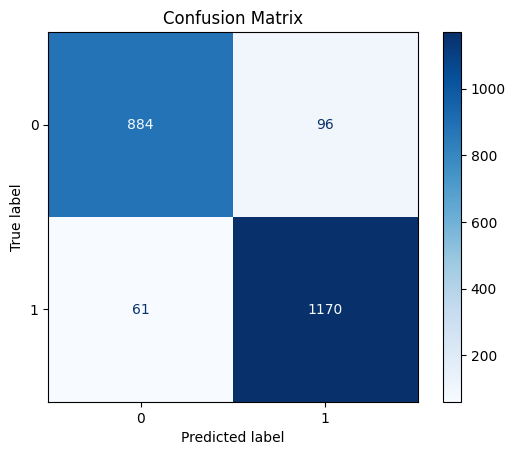

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# training logistic regression model as baseline
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_raw, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_raw)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Logistic Regression Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Comparison to LogReg Baseline

To round out the experiment, we trained a Logistic Regression model as a baseline and compared it to the neural network. The Logistic Regression achieved 92.90% test accuracy with slightly lower precision and recall for both classes, while the neural network reached 96.65% accuracy, with precision and recall above 96% for both classes.

The neural network performs better because it can capture non-linear relationships in the data using its hidden layer with ReLU activation, whereas Logistic Regression is limited to modeling linear decision boundaries. Additionally, the neural network benefits from mini-batch training, adaptive learning via the Adam optimizer, and longer training with early stopping, which allows it to learn more complex patterns without overfitting. Logistic Regression is simpler and faster to train, but its inherent linear assumption limits performance on large/high dimension datasets with non-linear feature interactions, which explains why the NN achieves higher accuracy and more balanced predictions across classes. We can see from the confusion matrices that the NN greatly reduces cases of both false positives/negatives which makes it a far better model in detecting phishing threats.